## Import necessary modules
Run this cell before running any other cells

<hr>

# BLE
## ArtemisBLEController
The class **ArtemisBLEController** (defined in *ble.py*) provides member functions to handle various BLE operations to send and receive data to/from the Artemis board, provided the accompanying Arduino sketch is running on the Artemis board. <br>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Functions</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">reload_config()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Reload changes made in <em>connection.yaml.</em></span></th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">connect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Connect to the Artemis board, whose MAC address is specified in <em>connection.yaml</em>.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">disconnect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Disconnect from the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">is_connected()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Return a boolean indicating whether your controller is connected to the Artemis board or not.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">send_command(cmd_type, data)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Send the command <strong>cmd_type</strong> (integer) with <strong>data</strong> (string) to the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">receive_float(uuid) <br> receive_string(uuid) <br> receive_int(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Read the GATT characteristic (specified by its <strong>uuid</strong>) of type float, string or int. <br> The type of the GATT
            characteristic is determined by the classes BLEFloatCharacteristic, BLECStringCharacteristic or
            BLEIntCharacteristic in the Arduino sketch.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">start_notify(uuid, notification_handler)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Activate notifications on the GATT characteristic (specified by its <strong>uuid</strong>). <br> <strong>notification_handler</strong> is a
            function callback which must accept two inputs; the first will be a uuid string object and the second will
            be the bytearray of the characteristic value.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">bytearray_to_float(byte_array) <br> bytearray_to_string(byte_array) <br> bytearray_to_int(byte_array)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Convert the <strong>bytearray</strong> to float, string or int, respectively. <br> You may use these functions inside your
            notification callback function.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">stop_notify(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Stop notifications on the GATT characteristic (specified by its <strong>uuid</strong>).</span></th>
    </tr>
</table>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Variables</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">uuid</span></th>
        <th style="text-align: left"><span style="font-weight: normal">A dictionary that stores the UUIDs of the various characteristics specified in <em>connection.yaml</em>.</span></th>
    </tr>
</table>

In the below cell, we create an **ArtemisBLEController** object using **get_ble_controller()** (defined in *ble.py*), which creates and/or returns a single instance of **ArtemisBLEController**. <br>
<span style="color:rgb(240,50,50)"> __NOTE__: Do not use the class directly to instantiate an object. </span><br>

In [22]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2024-02-13 12:54:53,045 | INFO     |: Already connected to a BLE device


In [26]:
ble.send_command(CMD.ECHO, "echo")

Robot says -> echo :)


In [6]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

Robot says -> echo :)


In [4]:
messages = []
temps = []
times = []
coords = []
pitches = []
rolls = []
lp_pitches = []
lp_rolls = []
def notification_handler(uuid, byte_array):
    global messages
    global temps
    global times
    global pitches
    global rolls
    global lp_pitches
    global lp_rolls
    s = ble.bytearray_to_string(byte_array)
    if "@" in s:
        s=s.split("@")
        temps.append(s[0][6:])
        times.append(s[1][6:])
    elif "T:" in s:
        times.append(s[2:])
    elif "LPAcc" in s:
        s = s[5:].split()
        pitches.append(s[0])
        rolls.append(s[1])
        lp_pitches.append(s[2])
        lp_rolls.append(s[3])
        times.append(s[4])
    elif "Acc" in s:
        s = s[3:].split()
        pitches.append(s[0])
        rolls.append(s[1])
        times.append(s[2])
        
    messages.append(s)
    print(s)

In [25]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

ValueError: Characteristic notifications already started

In [11]:
times = []
ble.send_command(CMD.SAMPLE_TIME, "")

T:873924.0
T:873924.0
T:873924.0
T:873924.0
T:873949.0
T:873968.0
T:873968.0
T:873978.0
T:873988.0
T:873988.0
T:873998.0
T:873998.0
T:874008.0
T:874018.0
T:874028.0
T:874028.0
T:874028.0
T:874038.0
T:874055.0
T:874055.0
T:874055.0
T:874073.0
T:874073.0
T:874084.0
T:874084.0
T:874102.0
T:874102.0
T:874102.0
T:874112.0
T:874118.0
T:874128.0
T:874128.0
T:874128.0
T:874146.0
T:874146.0
T:874174.0
T:874174.0
T:874190.0
T:874201.0
T:874201.0
T:874217.0
T:874217.0
T:874230.0
T:874246.0
T:874246.0
T:874267.0
T:874267.0
T:874277.0
T:874292.0
T:874292.0
T:874313.0
T:874313.0
T:874323.0
T:874339.0
T:874355.0
T:874355.0
T:874355.0
T:874365.0
T:874385.0
T:874401.0
T:874401.0
T:874411.0
T:874411.0
T:874428.0
T:874428.0
T:874428.0
T:874445.0
T:874445.0
T:874474.0
T:874474.0
T:874491.0
T:874501.0
T:874501.0
T:874518.0
T:874518.0
T:874535.0
T:874545.0
T:874545.0
T:874562.0
T:874562.0
T:874579.0
T:874589.0
T:874589.0
T:874606.0
T:874626.0
T:874626.0
T:874636.0
T:874636.0
T:874653.0
T:874653.0
T:874653.0

In [12]:
print(len(times))

634


In [13]:
times = []
ble.send_command(CMD.SEND_TIME_DATA, "")

T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450650.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:2450651.0
T:24

In [14]:
print(times)

['2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450650.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0', '2450651.0'

In [ ]:
ble.send_command(CMD.GET_TEMP_READINGS, "")
for i in range(100):
    print(temps[i]+" deg Celsius at "+times[i])

In [8]:
print(times)

['3362053.0', '3362053.0', '3362053.0', '3362054.0', '3362054.0', '3362054.0', '3362054.0', '3362054.0', '3362055.0', '3362055.0', '3362055.0', '3362055.0', '3362056.0', '3362056.0', '3362056.0', '3362056.0', '3362057.0', '3362057.0', '3362057.0', '3362057.0', '3362057.0', '3362059.0', '3362059.0', '3362059.0', '3362059.0', '3362060.0', '3362060.0', '3362060.0', '3362060.0', '3362061.0', '3362061.0', '3362061.0', '3362061.0', '3362061.0', '3362062.0', '3362062.0', '3362062.0', '3362062.0', '3362063.0', '3362063.0', '3362063.0', '3362063.0', '3362064.0', '3362064.0', '3362064.0', '3362064.0', '3362064.0', '3362069.0', '3362069.0', '3362069.0', '3362069.0', '3362070.0', '3362070.0', '3362070.0', '3362070.0', '3362071.0', '3362071.0', '3362071.0', '3362071.0', '3362072.0', '3362072.0', '3362072.0', '3362072.0', '3362072.0', '3362073.0', '3362073.0', '3362073.0', '3362073.0', '3362074.0', '3362074.0', '3362074.0', '3362074.0', '3362074.0', '3362076.0', '3362076.0', '3362076.0', '3362076.0'

In [ ]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [20]:
pitches = []
rolls = []
times = []
ble.send_command(CMD.GET_ACCEL_READINGS, "")

['6.673', '0.488', '1200640.0']
['6.451', '0.109', '1200692.0']
['7.200', '0.874', '1200744.0']
['8.58', '0.188', '1200796.0']
['7.701', '0.545', '1200848.0']
['6.999', '0.577', '1200900.0']
['8.115', '0.620', '1200952.0']
['7.553', '0.274', '1201004.0']
['7.431', '0.410', '1201056.0']
['7.410', '0.135', '1201108.0']
['7.761', '0.82', '1201160.0']
['7.296', '0.245', '1201212.0']
['7.706', '0.108', '1201264.0']
['7.698', '0.599', '1201316.0']
['7.799', '0.217', '1201368.0']
['7.135', '0.488', '1201420.0']
['7.482', '0.0', '1201472.0']
['7.696', '0.0', '1201524.0']
['7.610', '0.135', '1201576.0']
['7.562', '0.890', '1201628.0']
['7.175', '0.163', '1201680.0']
['7.932', '0.378', '1201732.0']
['7.546', '0.299', '1201784.0']
['7.812', '0.324', '1201836.0']
['7.316', '0.322', '1201888.0']
['8.412', '0.484', '1201940.0']
['7.665', '0.80', '1201992.0']
['7.541', '0.541', '1202044.0']
['7.277', '0.243', '1202096.0']
['7.598', '0.81', '1202148.0']
['8.507', '0.134', '1202200.0']
['7.385', '0.216

## Disconnect

In [31]:
pitches = []
rolls = []
times = []
lp_pitches = []
lp_rolls = []
ble.send_command(CMD.LP_ACCEL_READINGS, "")

['9.471', '4.15', '9.471', '4.15', '2375118.0']
['9.206', '4.174', '9.307', '4.113', '2375170.0']
['9.627', '4.533', '9.467', '4.397', '2375222.0']
['9.746', '3.952', '9.701', '4.173', '2375274.0']
['9.570', '3.345', '9.637', '3.576', '2375326.0']
['9.689', '3.211', '9.644', '3.262', '2375378.0']
['9.297', '3.817', '9.446', '3.587', '2375430.0']
['9.852', '4.536', '9.641', '4.263', '2375482.0']
['9.315', '4.442', '9.519', '4.478', '2375534.0']
['9.636', '3.715', '9.514', '3.991', '2375586.0']
['9.904', '3.989', '9.802', '3.885', '2375638.0']
['10.104', '4.209', '10.28', '4.126', '2375690.0']
['9.716', '4.587', '9.863', '4.443', '2375742.0']
['9.827', '4.273', '9.785', '4.392', '2375794.0']
['10.116', '4.10', '10.6', '4.110', '2375846.0']
['9.722', '3.837', '9.872', '3.903', '2375898.0']
['9.989', '3.662', '9.887', '3.728', '2375950.0']
['9.719', '4.368', '9.822', '4.100', '2376002.0']
['9.775', '4.156', '9.754', '4.236', '2376054.0']
['10.9', '3.704', '9.920', '3.876', '2376106.0']
['1

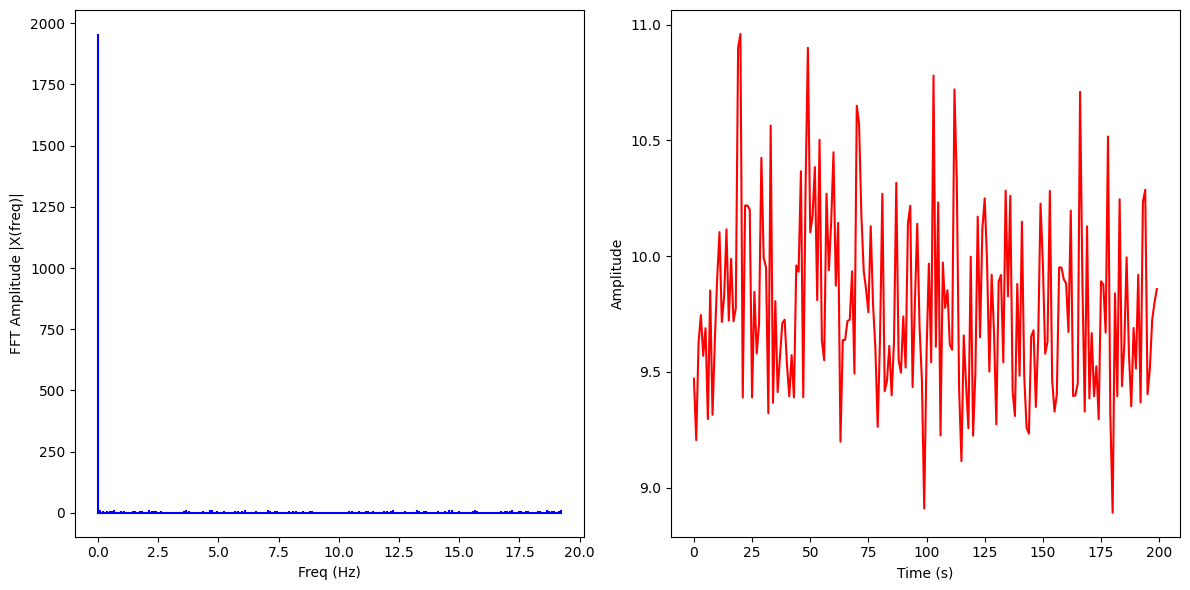

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
X = fft(pitches)
N = 200
n = np.arange(N)
T = 10.348
freq = n/T
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

tmp = []
for p in pitches:
    tmp.append(float(p))
plt.subplot(122)
plt.plot(range(200), np.abs(ifft(X)), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [22]:
print(200/((float(times[199])-float(times[0]))/1000.0))
print(float(times[199])-float(times[0]))

19.327406262079627
10348.0


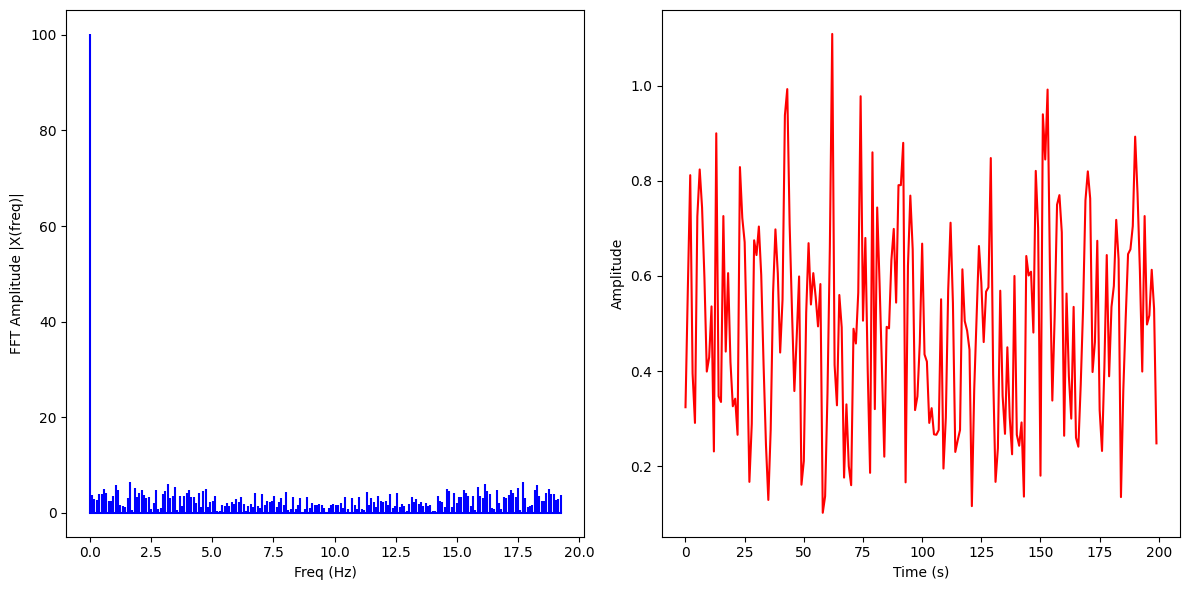

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
X = fft(lp_pitches)
N = 200
n = np.arange(N)
T = 10.348
freq = n/T
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

tmp = []
for p in lp_pitches:
    tmp.append(float(p))
plt.subplot(122)
plt.plot(range(200), np.abs(ifft(X)), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

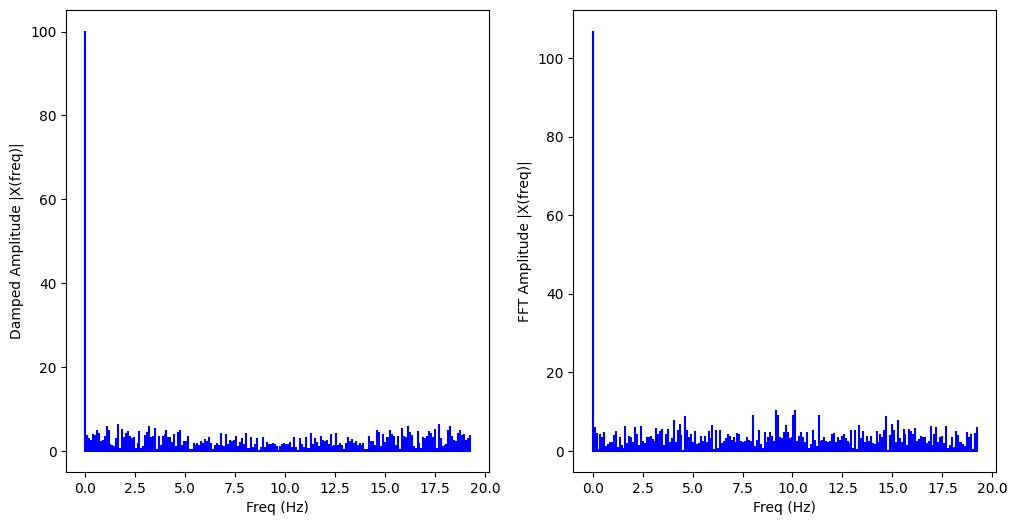

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
LX = fft(lp_pitches)
N = 200
n = np.arange(N)
T = 10.348
freq = n/T
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(LX), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Damped Amplitude |X(freq)|')


X = fft(pitches)
# plt.figure(figsize = (12, 6))
plt.subplot(122)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')


# tmp = []
# for p in lp_pitches:
#     tmp.append(float(p))
# plt.subplot(122)
# plt.plot(range(200), tmp, 'r')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.tight_layout()
# plt.show()

In [ ]:
# below is 10 Hz cutoff freq, above is 5Hz?

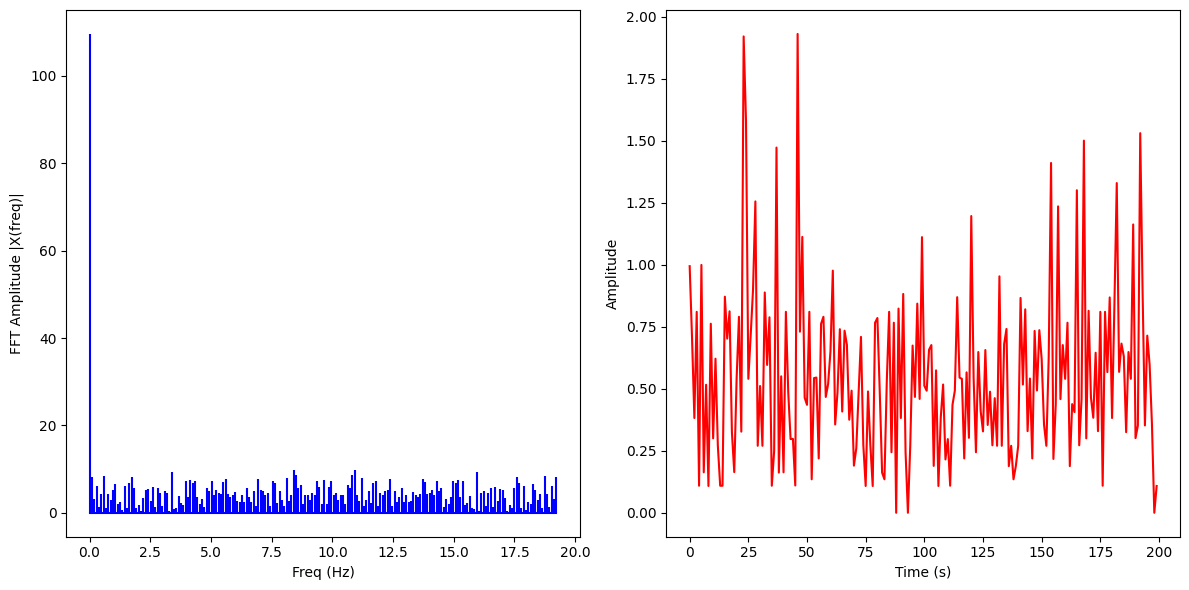

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
X = fft(pitches)
N = 200
n = np.arange(N)
T = 10.348
freq = n/T
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

tmp = []
for p in pitches:
    tmp.append(float(p))
plt.subplot(122)
plt.plot(range(200), np.abs(ifft(X)), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

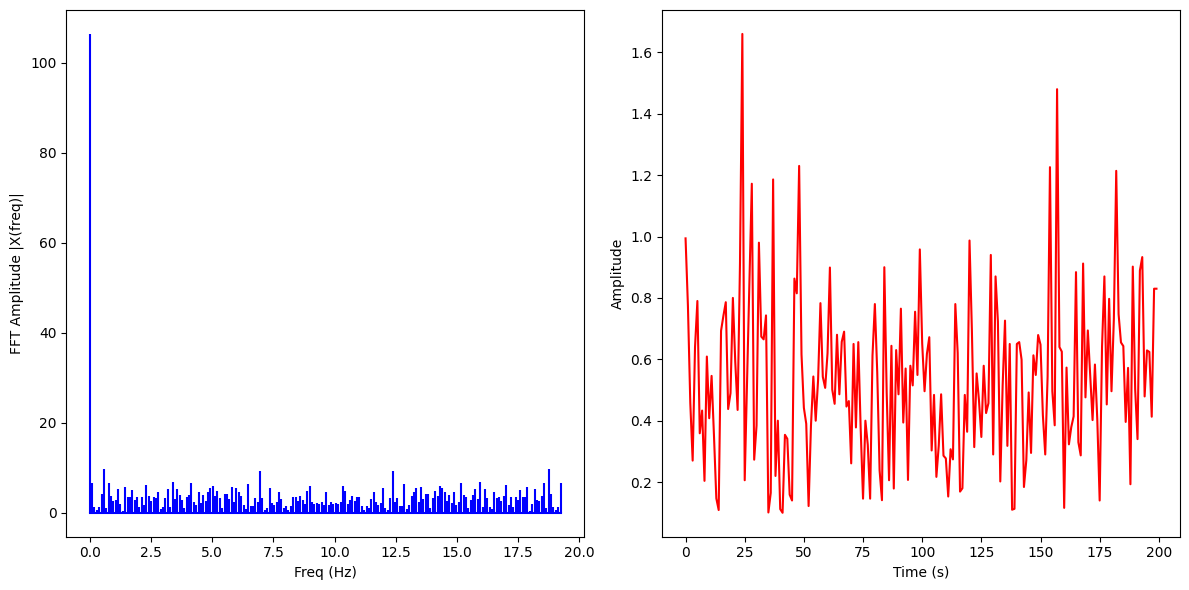

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
X = fft(lp_pitches)
N = 200
n = np.arange(N)
T = 10.348
freq = n/T
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

tmp = []
for p in pitches:
    tmp.append(float(p))
plt.subplot(122)
plt.plot(range(200), np.abs(ifft(X)), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

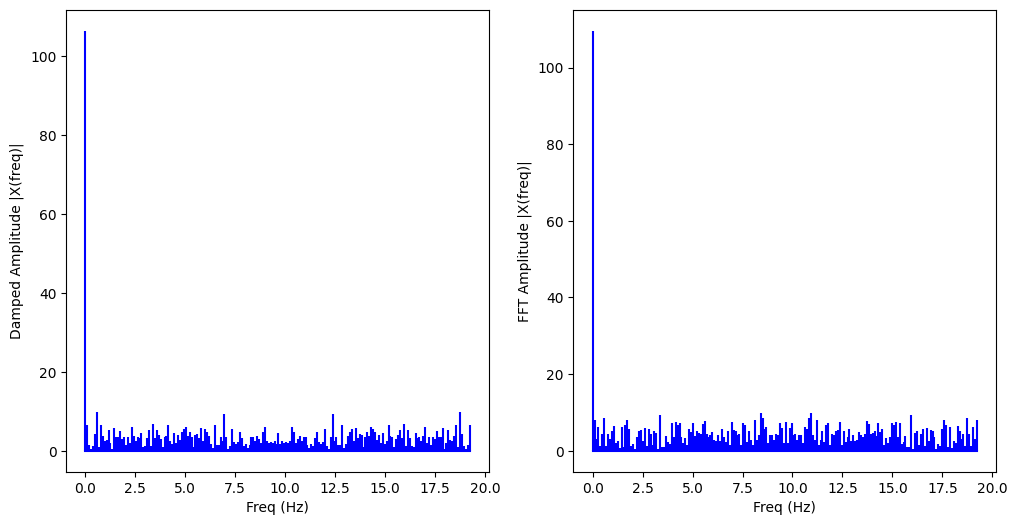

2024-02-12 18:49:11,408 | INFO     |: Disconnected from 2C7E7BE8-D5AB-1F34-3582-913588F90853


In [57]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
LX = fft(lp_pitches)
N = 200
n = np.arange(N)
T = 10.348
freq = n/T
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(LX), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Damped Amplitude |X(freq)|')


X = fft(pitches)
# plt.figure(figsize = (12, 6))
plt.subplot(122)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')


# tmp = []
# for p in lp_pitches:
#     tmp.append(float(p))
# plt.subplot(122)
# plt.plot(range(200), tmp, 'r')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.tight_layout()
# plt.show()

In [7]:
# Disconnect
ble.disconnect()

2024-01-30 15:41:52,951 | INFO     |: Disconnected from 2C7E7BE8-D5AB-1F34-3582-913588F90853
